In [1]:
# Install libraries for data_loader
!pip install pandas
!pip install sklearn
#!pip install albumentations
!pip install torchvision
!pip install tqdm
!pip install torchmetrics

In [53]:
# Import DataLoader and corresponding libraries
import pandas
import torchvision.transforms as TT
# import albumentations as T
# import albumentations.augmentations.transforms as T_transforms
# from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset, sampler
from sklearn.model_selection import StratifiedKFold
from torchvision import utils
from PIL import Image

In [54]:
# Import libraries for tensors
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# For fbeta-score
from torchmetrics.functional import fbeta_score

# For nn.Sequential
from collections import OrderedDict

In [55]:
# Import tqdm for progress bar construction
import tqdm

In [56]:
# Datatypes and Devices (from Assignment 2)
dtype = torch.float
ltype = torch.long

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [57]:
# Hyper-parameters for K-Fold Cross Validation
N = 5
seed = 42

# Directories for Data
FF1010_Path = 'C:\\users\\ujubo\\birdnocall\\'
AudioImage_Path = './image/'

In [58]:
# Call StratifiedKFold object
skf = StratifiedKFold(
    n_splits=5, shuffle=True, random_state=seed
)

In [59]:
# Modify dataframe for K-Fold Cross Validation (ff1010)
ff1010_csv = pandas.read_csv(FF1010_Path + 'metadata.csv')
#no call
ff1010_csv.loc[ff1010_csv['hasbird'] == 0, 'filepath'] = \
    FF1010_Path + 'nocall/' + ff1010_csv.query('hasbird == 0')['filename'] + '.npy'
#call
ff1010_csv.loc[ff1010_csv['hasbird'] == 1, 'filepath'] = \
    FF1010_Path + 'bird/' + ff1010_csv.query('hasbird == 1')['filename'] + '.npy'


ff1010_csv = ff1010_csv.dropna()
ff1010_csv = ff1010_csv.reset_index(drop=True)

# Add 'fold' attribute for dataset classification
ff1010_dataframe = ff1010_csv.copy()
for n, (_, nth_groups) in enumerate(
    skf.split(ff1010_dataframe, ff1010_dataframe['hasbird'])):
    ff1010_dataframe.loc[nth_groups, 'fold'] = int(n)

In [60]:
# # Modify dataframe for K-Fold Cross Validation (birdclef2021)
# birdclef_csv = pandas.read_csv(AudioImage_Path + 'metadata.csv')
# birdclef_csv.loc[birdclef_csv['label_id'] >= 0,'filepath'] = \
#     AudioImage_Path + birdclef_csv.query('label_id >= 0')['primary_label'] + '/' + \
#     birdclef_csv.query('label_id >= 0')['filename'] + '.npy'

# birdclef_csv = birdclef_csv.dropna()
# birdclef_csv = birdclef_csv.reset_index(drop=True)

# # Add 'fold' attribute for dataset classification
# birdclef_dataframe = birdclef_csv.copy()
# for n, (_, nth_groups) in enumerate(
#     skf.split(birdclef_dataframe, birdclef_dataframe['label_id'])):
#     birdclef_dataframe.loc[nth_groups, 'fold'] = int(n)

In [61]:
# Hyper-parameters for training 
ff1010_batch = 32
birdclef_batch = 32

In [90]:
# Class for ff1010 dataset
class FF1010(Dataset):
    def __init__(self, dataframe, process='train', labels='hasbird'):
        self.dataframe = dataframe
        self.filepaths = dataframe['filepath'].values
        self.labels = dataframe[labels].values
        self.process = process
        
        # Transforms for each train and validation
        self.train_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.RandomHorizontalFlip(p=0.5),
            TT.RandomVerticalFlip(p=0.5),
#             T_transforms.ImageCompression(p=0.5, 
#                 compression_type=T_transforms.ImageCompression.ImageCompressionType.JPEG),
#             T_transforms.ImageCompression(p=0.5, 
#                 compression_type=T_transforms.ImageCompression.ImageCompressionType.WEBP),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.val_transform = TT.Compose([
            TT.Resize([128, 281]),
            TT.ToTensor(),
            TT.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
    
    def __getitem__(self, idx):
        source = np.load(self.filepaths[idx])
        
        # Rearrange numpy arrays
        source = source.transpose(1, 2, 0)
        # Add RGB dimension
        source = np.stack((np.squeeze(source), ) * 3, -1)
        
        # Apply transform
        if self.process == 'train':
            source = self.train_transform(Image.fromarray(source))
        elif self.process == 'valid':
            source = self.val_transform(Image.fromarray(source))
        elif self.process == 'test':
            source = self.val_transform(Image.fromarray(source))
        
        return source, torch.tensor(self.labels[idx], dtype=ltype).to(device)
    
    def __len__(self):
        return len(self.dataframe)

In [91]:
def evaluate_model(loader, model, beta=1.0):
  # TODO: extend this so that we can print that we evaluate test set.
  num_correct = 0
  num_samples = 0
  log_sum = 0
  fbeta_sum = 0
  model.eval()
  
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device, dtype=torch.float)
      y = y.to(device=device, dtype=torch.long)
      scores = model(x)
      # scores means classfication class for each class. It should be the tensor with size of (Input size, Number of classes)
      # In binary classification, it should be (batch size, 2) sized tensor

      # Checks naive accuracy.
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)

      # Checks Log Loss.
      # TODO: change this to F.cross_entropy()
      log_loss = F.nll_loss(F.log_softmax(scores, dim=0), y)
      log_sum += log_loss.sum(0) * preds.size(0)

      # Checks Fbeta-score.
      fbeta = fbeta_score(preds, y, beta=beta)
      fbeta_sum += fbeta * preds.size(0)

    acc = float(num_correct) / num_samples
    log_score = log_sum / num_samples
    f_score = fbeta_sum / num_samples
    print('\nAccuracy: %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    print('Log Loss score:\t%.2f' % (log_score))
    print('Fbeta-score (beta=%d): \t%.2f' % (beta , f_score))
  return acc, log_score, f_score

In [143]:
# Print period for accuracy.
print_period = 12

# Learning Rate.
learning_rate_1 = 0.0001

# L2 Regularization Hyperparamter
weight_decay_1 = 0.01

# Beta constant for Fbeta-score.
# If you want to give more weight to precision, use value smaller than 1.0.
# If you want to give more weight to recall, use value larger than 1.0.
beta = 1.0

# Prototype of model 1.
# ResNet50 outputs (Batchsize, 1000) tensor as output, so we reduce them to 2.
# TODO: I'm curious about the output of the model: would output be the float number
#       between 0 and 1? If not, we need to add sigmoid or softmax function at the end.
#       (EDIT) It looks like we're ok with training.

model_1 = nn.Sequential(OrderedDict([
        ("resnet50", torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True).to(device)),
        ("relu", nn.ReLU().to(device)),
        ("linear", nn.Linear(1000, 2, bias=True).to(device))
]))

print(model_1)

def train_model(model, train_loader, val_loader, test_loader, optimizer, beta=1.0, epoch=7):
    val_losses = []
    train_losses = []
    test_losses = []
    vlog_scores = []
    vfbeta_scores = []
    tlog_scores = []
    tfbeta_scores = []
    
    loss = 0
    log_score = 0
    test_score = 0
    
    for e in range(epoch):
        print(f"Training model 1, epoch {e+1}")
        for index, (source, label) in enumerate(tqdm.tqdm(train_loader)):
            x = source.to(device=device, dtype=torch.float)  # move to device, e.g. GPU
            y = label.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.nll_loss(F.log_softmax(scores, dim=0), y) # Log loss for our project.
            train_losses.append(loss)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # every print_period, evaluate on val_loader.
            if index % print_period == 0:
                print('Iteration %d, loss = %.4f' % (index, loss.item()))
                print()
    
    
        print("\nChecking accuracy score on validation set.")
        acc, log_score, fbeta_score = evaluate_model(val_loader, model, beta=beta)
        val_losses.append(acc)
        vlog_scores.append(log_score)
        vfbeta_scores.append(fbeta_score)
        
        print("\nChecking accuracy score on test set.")
        acc, log_score, fbeta_score = evaluate_model(test_loader, model, beta=beta)
        test_losses.append(acc)
        tlog_scores.append(log_score)
        tfbeta_scores.append(fbeta_score)
    
    return test_losses, val_losses, train_losses, vlog_scores, vfbeta_scores, tlog_scores, tfbeta_scores

Using cache found in C:\Users\ujubo/.cache\torch\hub\pytorch_vision_v0.10.0


Sequential(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [144]:
from time import sleep

# Train loop for nocall detector
def nocall_train(train_dataframe, val_dataframe, test_dataframe):  
    train_data = FF1010(train_dataframe, process='train', labels='hasbird')
    val_data = FF1010(val_dataframe, process='valid', labels='hasbird')
    test_data = FF1010(test_dataframe, process='test', labels='hasbird')
    
    # Construct data loader for train and validation
    train_loader = DataLoader(train_data, batch_size=ff1010_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(train_dataframe))), 
                             drop_last=True)
    val_loader = DataLoader(val_data, batch_size=ff1010_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    test_loader = DataLoader(test_data, batch_size=ff1010_batch,
                             sampler=sampler.SubsetRandomSampler(range(len(val_dataframe))),
                             drop_last=False)
    
    # Test for loaders
    
    optimizer = optim.SGD(model_1.parameters(), lr=learning_rate_1, momentum=0.5, weight_decay=weight_decay_1)
    test_losses, val_losses, train_losses, vlog_scores, vfbeta_scores, tlog_scores, tfbeta_scores = \
    train_model(model_1, train_loader, val_loader, test_loader, optimizer, beta=beta)
    
    
    return test_losses, val_losses, train_losses, vlog_scores, vfbeta_scores, tlog_scores, tfbeta_scores

In [145]:
# Train, Validate and Test for nocall detector
def nocall(dataframe, val_index, test_index):
    
    # Check that validation fold is not same as test fold
    assert val_index != test_index, \
        'Validation and test should be done on different fold.'
    
    train_dataframe = dataframe.query(
        'fold != ' + str(val_index) + ' and fold != ' + str(test_index) 
    ).reset_index(drop=True)
    val_dataframe = dataframe.query(
        'fold == ' + str(val_index) 
    ).reset_index(drop=False)
    test_dataframe = dataframe.query(
        'fold == ' + str(test_index) 
    ).reset_index(drop=False)
    
    test_losses, val_losses, train_losses, vlog_scores, vfbeta_scores, tlog_scores, tfbeta_scores = \
    nocall_train(train_dataframe, val_dataframe, test_dataframe)
    
    # TODO
    # 이쪽에 Accuracy test 구현하시면 됩니다.
    
    return test_losses, val_losses, train_losses, vlog_scores, vfbeta_scores, tlog_scores, tfbeta_scores

In [ ]:
test_losses, val_losses, train_losses, log_socers, fbeta_scores = nocall(ff1010_dataframe, 0, 1)

Training model 1, epoch 1


  1%|▌                                                                                 | 1/144 [00:03<09:05,  3.81s/it]

Iteration 0, loss = 3.5475



  9%|███████▎                                                                         | 13/144 [00:49<08:20,  3.82s/it]

Iteration 12, loss = 3.5641



 17%|██████████████                                                                   | 25/144 [01:36<07:45,  3.91s/it]

Iteration 24, loss = 3.6649



 26%|████████████████████▊                                                            | 37/144 [02:22<06:56,  3.89s/it]

Iteration 36, loss = 3.6739



 34%|███████████████████████████▌                                                     | 49/144 [03:09<06:05,  3.85s/it]

Iteration 48, loss = 3.5080



 42%|██████████████████████████████████▎                                              | 61/144 [03:55<05:21,  3.87s/it]

Iteration 60, loss = 3.6095



 51%|█████████████████████████████████████████                                        | 73/144 [04:41<04:34,  3.87s/it]

Iteration 72, loss = 3.4190



 59%|███████████████████████████████████████████████▊                                 | 85/144 [05:29<03:57,  4.03s/it]

Iteration 84, loss = 3.5400



 60%|████████████████████████████████████████████████▉                                | 87/144 [05:37<03:48,  4.00s/it]

C:\Users\ujubo\AppData\Local\Temp/ipykernel_11940/4126914523.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_losses = torch.tensor(val_losses, device = 'cpu')


Text(0.5, 1.0, 'Validation Accuracy Curve of Nocall Detector')

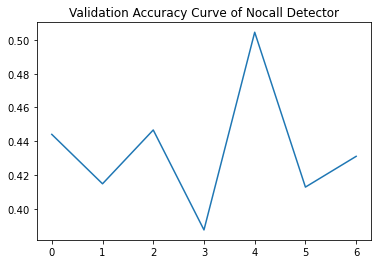

In [138]:
val_losses = torch.tensor(val_losses, device = 'cpu')
plt.plot(np.arange(len(val_losses)), val_losses)
plt.title('Validation Accuracy Curve of Nocall Detector')

Text(0.5, 1.0, 'Test Accuracy Curve of Nocall Detector')

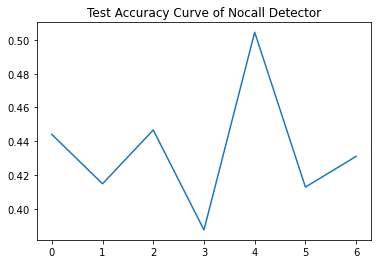

In [139]:
test_losses = torch.tensor(test_losses, device = 'cpu')
plt.plot(np.arange(len(test_losses)), val_losses)
plt.title('Test Accuracy Curve of Nocall Detector')

tensor([])


C:\Users\ujubo\AppData\Local\Temp/ipykernel_11940/3509005311.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_scores = torch.tensor(log_scores, device = 'cpu')


Text(0.5, 1.0, 'Log-score Curve of Nocall Detector')

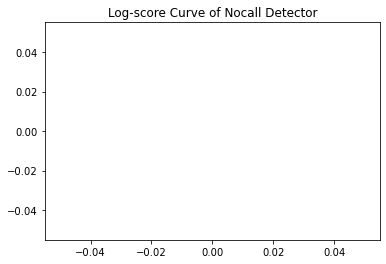

In [142]:
vlog_scores = torch.tensor(vlog_scores, device = 'cpu')
plt.plot(np.arange(len(vlog_scores)), vlog_scores)
plt.title('Log-score Curve of Nocall Detector')

Text(0.5, 1.0, 'F-beta score Curve of Nocall Detector')

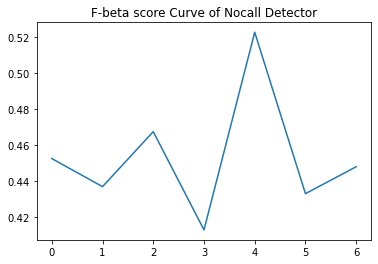

In [141]:
vfbeta_scores = torch.tensor(vfbeta_scores, device = 'cpu')
plt.plot(np.arange(len(vfbeta_scores)), vfbeta_scores)
plt.title('F-beta score Curve of Nocall Detector')

In [ ]:
tlog_scores = torch.tensor(tlog_scores, device = 'cpu')
plt.plot(np.arange(len(tlog_scores)), tlog_scores)
plt.title('Log-score Curve of Nocall Detector')

In [ ]:
tfbeta_scores = torch.tensor(tfbeta_scores, device = 'cpu')
plt.plot(np.arange(len(tfbeta_scores)), tfbeta_scores)
plt.title('F-beta score Curve of Nocall Detector')